In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sn
sn.color_palette("hls", 17)
import scipy.stats as st
import math

from pingouin import rcorr

In [2]:
import sys
import os
sys.path.append(os.path.join(".."))

from module.trend_analysis_functions import *
from module.topic_model_plus_class import Topic_Model_plus

In [3]:
csv_file_name = os.path.join(os.path.dirname(os.getcwd()),'data','safecom-2011-present-NASA.xlsx')
df = pd.read_excel(csv_file_name,sheet_name='safecom-2011-present-NASA')
df['fiscal_year'].value_counts()

C:\Users\srandrad\Anaconda3\lib\site-packages\openpyxl\compat\numbers.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.float,


2021    2543
2020    1392
2016     998
2018     943
2017     894
2015     714
2019     611
2014       3
2009       1
Name: fiscal_year, dtype: int64

In [4]:
list_of_attributes = ['narr_public']#, 'corrective_public', 'notes']
extra_cols = ['region', 'agency', 'duplicate_yn', 'completed_yn', 'rep_by_org',
                   'air_number', 'air_type', 'air_model', 'air_manufacturer',
                   'air_owner', 'mission_destination', 'mission_depart', 'mission_hazmat',
                   'mission_special_use', 'mission_pax', 'mission_procurement_other',
                   'mission_procurement', 'mission_type_other', 'mission_type',
                   'event_damage', 'event_injuries', 'event_org', 'event_org_other',
                   'event_state', 'event_location', 'event_time', 'event_date',
                   'public_yn', 'sequence_number', 'fiscal_year', 'unitid', 'safecomid',
                   'id']
document_id_col = 'id'
csv_file_name = os.path.join(os.path.dirname(os.getcwd()),'data','safecom-2011-present-NASA.xlsx')

file = os.path.join(os.path.dirname(os.getcwd()),'results','test_safecom_topics-Sep-21-2021','preprocessed_data.csv')
safecom = Topic_Model_plus(document_id_col=document_id_col, extra_cols=extra_cols, list_of_attributes=list_of_attributes, combine_cols=False)
safecom.extract_preprocessed_data(file)
preprocessed_df = safecom.data_df

In [5]:
preprocessed_df = preprocessed_df.loc[preprocessed_df['fiscal_year']>2014].reset_index(drop=True)

In [6]:
hazard_file = os.path.join(os.path.dirname(os.getcwd()),'results','test_safecom_topics-Sep-21-2021','hazard_interpretation_SAFECOM_V0.xlsx')
results_file = os.path.join(os.path.dirname(os.getcwd()),'results','test_safecom_topics-Sep-21-2021','lda_results.xlsx')

In [7]:
hazard_info = pd.read_excel(hazard_file, sheet_name=['topic-focused'])
hazard_info

{'topic-focused':    Topic Number  Unnamed: 1  Topic Level  Unnamed: 3  \
 0            33         NaN            1         NaN   
 1            87         NaN            1         NaN   
 2             7         NaN            1         NaN   
 
                                Relevant hazard words  Unnamed: 5  Unnamed: 6  \
 0  hydraulic, fluid, hydraulic fluid, leak, hydra...         NaN         NaN   
 1  drone, law, enforcement, law enforcement, oper...         NaN         NaN   
 2  bucket, water, dip, dip site, drop, site, wate...         NaN         NaN   
 
    Relevant Category words  Unnamed: 8  Unnamed: 9  Best Document  \
 0                      NaN         NaN         NaN            NaN   
 1                      NaN         NaN         NaN            NaN   
 2                      NaN         NaN         NaN            NaN   
 
    Unnamed: 11  Quality  Negation words  Unnamed: 14  Hazard Category  \
 0          NaN      NaN             NaN          NaN              NaN 

In [8]:
frequency, docs = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, "narr_public", 'fiscal_year', "id")

In [9]:
print(frequency)

{'Drone Incursion': {'2020': 39, '2015': 19, '2021': 19, '2018': 26, '2019': 14, '2016': 35, '2017': 41}, 'Water Drop': {'2020': 157, '2015': 129, '2021': 119, '2018': 131, '2019': 65, '2016': 124, '2017': 120}, 'Hydraulic Fluid Issues': {'2020': 25, '2015': 19, '2021': 23, '2018': 35, '2019': 12, '2016': 35, '2017': 28}}


In [10]:
docs

{'Drone Incursion': {'2020': [25101,
   25120,
   25127,
   25128,
   25130,
   25131,
   25137,
   25175,
   25200,
   24039,
   23930,
   24119,
   24311,
   24315,
   24344,
   24390,
   24394,
   24404,
   24480,
   24466,
   23951,
   23954,
   24012,
   24150,
   24352,
   24363,
   24206,
   24533,
   24497,
   24687,
   24631,
   24511,
   24830,
   24933,
   25358,
   25405,
   25577,
   25578,
   25579],
  '2015': [19459,
   19433,
   19461,
   19473,
   19500,
   19520,
   19548,
   19563,
   19576,
   19693,
   19694,
   19695,
   19832,
   19918,
   19979,
   19993,
   20069,
   20073,
   20252],
  '2021': [25423,
   25537,
   26105,
   26112,
   26244,
   26359,
   26361,
   26675,
   26706,
   26839,
   26924,
   27249,
   27322,
   27343,
   27405,
   27407,
   27533,
   27858,
   28012],
  '2018': [22510,
   22252,
   22183,
   23069,
   22200,
   22225,
   22292,
   22316,
   22407,
   22410,
   22441,
   22538,
   22552,
   22568,
   22582,
   22657,
   22658,
   226

In [11]:
def safecom_severity(passengers, injury, damage):
    key_dict = {"f":0, "t":1}
    severity = float(passengers)*(key_dict[injury] + key_dict[damage])
    if np.isnan(severity):
        severity=0
    return severity

In [12]:
total_docs_per_year = preprocessed_df['fiscal_year'].value_counts()
total_docs_per_year[2020]

925

In [13]:
def create_table(docs, frequency, preprocessed_df, id_field, categories, subcategories, hazards, time_field):
    table = pd.DataFrame({"Category": categories, "Subcategory": subcategories, "Hazards": hazards})
    time_period = preprocessed_df[time_field].unique()
    severities = {name:{str(time_p):[] for time_p in time_period} for name in hazards}
    rates = {name:{str(time_p):0 for time_p in time_period} for name in hazards}
    total_docs_per_year = preprocessed_df[time_field].value_counts()
    total_rates = {hazard:0 for hazard in hazards}
    total_hazard_freq = {hazard:0 for hazard in hazards}
    total_severities_hazard = {hazard:0 for hazard in hazards}
    total_docs = len(preprocessed_df)
    for hazard in hazards:
        for year in docs[hazard]:
            for doc in docs[hazard][year]:
                doc_df = preprocessed_df.loc[preprocessed_df[id_field] == doc].reset_index(drop=True)
                severities[hazard][year].append(safecom_severity(doc_df.iloc[0]['mission_pax'], doc_df.iloc[0]['event_injuries'], doc_df.iloc[0]['event_damage']))
            rates[hazard][year] = frequency[hazard][year]/total_docs_per_year[int(year)]
            total_hazard_freq[hazard] += frequency[hazard][year]
        total_rates[hazard] = total_hazard_freq[hazard]/total_docs
        total_severities_hazard[hazard] = np.average([sev for year in severities[hazard] for sev in severities[hazard][year]])
    table["Frequency"] = [total_hazard_freq[hazard] for hazard in total_hazard_freq]
    table["Rate"] = [total_rates[hazard] for hazard in total_rates]
    table["Severity"] = [total_severities_hazard[hazard] for hazard in total_severities_hazard]
    return table, severities, rates
    

In [14]:
categories = ['Airspace','Incident','Maintenance',]
subcategories = ["UAS", 'Mission Equipment','Landing Gear']
hazards = ['Drone Incursion','Water Drop','Hydraulic Fluid Issues']
table, severities, rates = create_table(docs, frequency, preprocessed_df, "id", categories, subcategories, hazards, 'fiscal_year')

In [15]:
table

,Category,Subcategory,Hazards,Frequency,Rate,Severity
0,Airspace,UAS,Drone Incursion,193,0.035400,0.046632
1,Incident,Mission Equipment,Water Drop,845,0.154989,0.298225
2,Maintenance,Landing Gear,Hydraulic Fluid Issues,177,0.032465,0.141243


In [16]:
def plot_metric_time_series(metric_data, metric_name, line_styles=[], markers=[], title="", time_name="Year"):
    time_vals = list(set([year for hazard in metric_data for year in metric_data[hazard]]))
    time_vals.sort()
    averages = {hazard: [np.average(metric_data[hazard][year]) for year in time_vals] for hazard in metric_data}
    stddevs = {hazard: [np.std(metric_data[hazard][year]) for year in time_vals] for hazard in metric_data}
    colors = cm.tab20(np.linspace(0, 1, len(averages)))
    plt.figure()
    plt.title(title, fontsize=16)
    plt.xlabel(time_name, fontsize=16)
    plt.ylabel(metric_name, fontsize=16)
    i=0
    for hazard in averages:
        plt.errorbar(time_vals, averages[hazard], yerr=stddevs[hazard], color=colors[i], marker=markers[i], linestyle=line_styles[i], label=hazard, capsize=5, markeredgewidth=1)
        i += 1
    plt.legend(bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=14)
    plt.tick_params(labelsize=16)
    plt.show()
    

In [17]:
def plot_frequency_time_series(metric_data, metric_name='Frequency', line_styles=[], markers=[], title="", time_name="Year"):
    time_vals = list(set([year for hazard in metric_data for year in metric_data[hazard]]))
    time_vals.sort()
    frequencies = {hazard: [frequency[hazard][year] for year in time_vals] for hazard in frequency}
    hazard_freqs_scaled = {hazard: minmax_scale(frequencies[hazard]) for hazard in frequencies}
    colors = cm.tab20(np.linspace(0, 1, len(frequencies)))
    plt.figure()
    plt.ylabel("Total Scaled "+metric_name, fontsize=16)
    plt.xlabel(time_name, fontsize=16)
    plt.title(title, fontsize=16)
    i = 0
    for hazard in hazard_freqs_scaled:
        plt.plot(time_vals, hazard_freqs_scaled[hazard], color=colors[i], label=hazard, marker=markers[i], linestyle=line_styles[i])
        i += 1
    plt.legend(bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=14)
    plt.tick_params(labelsize=16)
    plt.show()

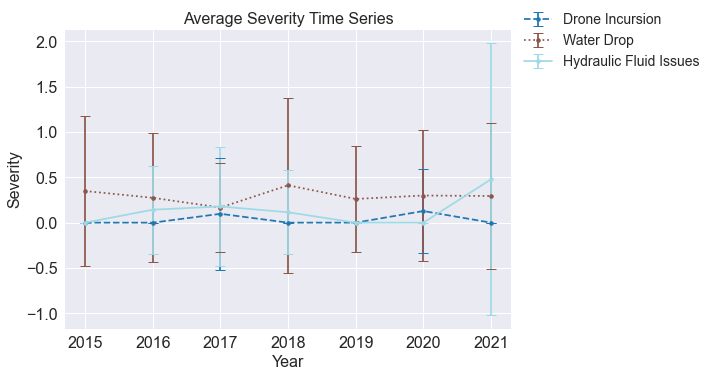

In [18]:
markers = ['.','.','.']
line_styles = ['--', ':','-']

plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="Average Severity Time Series", time_name='Year')

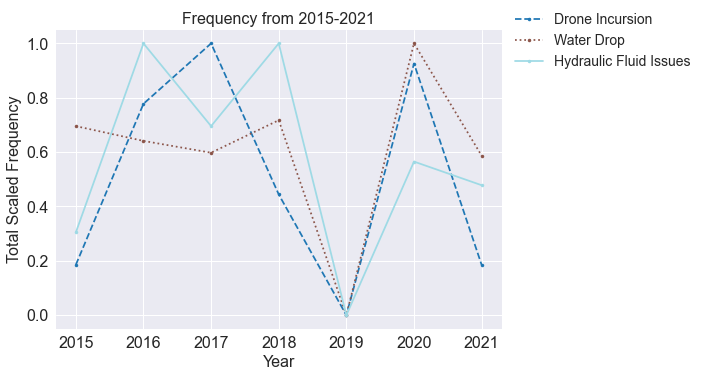

In [19]:
plot_frequency_time_series(frequency, metric_name='Frequency', line_styles=line_styles, markers=markers, title="Frequency from 2015-2021", time_name="Year")

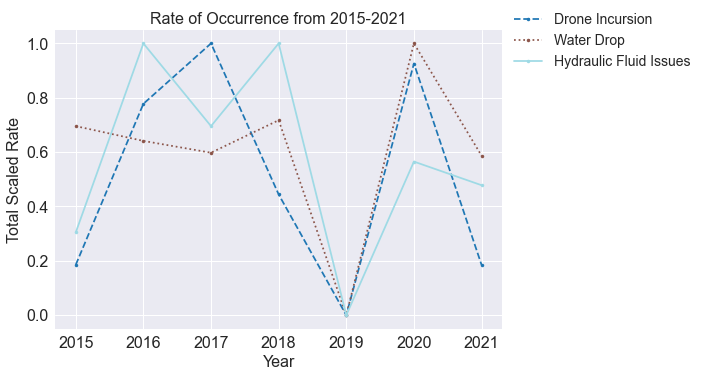

In [20]:
plot_frequency_time_series(rates, metric_name='Rate', line_styles=line_styles, markers=markers, title="Rate of Occurrence from 2015-2021", time_name="Year")